# Import Libraries and CSV File

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime as dt

In [38]:
df = pd.read_csv('kc2_house_data.csv')
df.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode,lat,long,yrs_old
0,221900.0,3,1.00,1.0,0.0,0.0,3,7,98178,47.5112,-122.257,59
1,538000.0,3,2.25,2.0,0.0,0.0,3,7,98125,47.7210,-122.319,63
2,180000.0,2,1.00,1.0,0.0,0.0,3,6,98028,47.7379,-122.233,82
3,604000.0,4,3.00,1.0,0.0,0.0,5,7,98136,47.5208,-122.393,49
4,510000.0,3,2.00,1.0,0.0,0.0,3,8,98074,47.6168,-122.045,28


# Bin zipcodes into zones comprised of multiples school districts

In [39]:
def group_zips(z):
    
    if z in [98198, 98023, 98003, 98001, 98002, 98092]:
        return 'FederalWay_Auburn'
    
    elif z in [98032, 98031, 98030, 98042, 98058, 98178, 98056, 98055, 98146, 98166, 98148, 98188, 98038, 98022, 98010]:
        return 'Kent_Renton_Highline_Tahoma_Enumclaw'
    
    
    elif z in [98177, 98133, 98125, 98155, 98019, 98014]:
        return 'Shoreline_Riverview'
    
    elif z in [98024, 98065, 98045, 98070]:
        return 'Snoqualmie_Vashon'

    elif z in [98117, 98103, 98115, 98107, 98105, 98199, 98119, 98109, 98102, 
               98112, 98122, 98116, 98136, 98126,
               98106, 98144, 98108, 98118, 98028, 98011, 98072, 98077]:
        return 'Seattle_Northshore'
    
    elif z in [98034, 98052, 98053, 98033, 98074, 98059, 98027, 98075, 98029]:
        return 'LakeWashington_Issaquah'
    
    elif z in [98040]:
        return 'MercerIsland'
    
    elif z in [98039, 98004, 98005, 98007, 98008, 98006]:
        return 'Bellevue'
    
    elif z in [98168]:
        return 'Tukwila'

In [40]:
df['zipcode'] = df['zipcode'].map(group_zips)

In [41]:
grouped_zip = df.loc[:,['zipcode', 'price']].groupby(['zipcode']).median().sort_values(by = 'price')

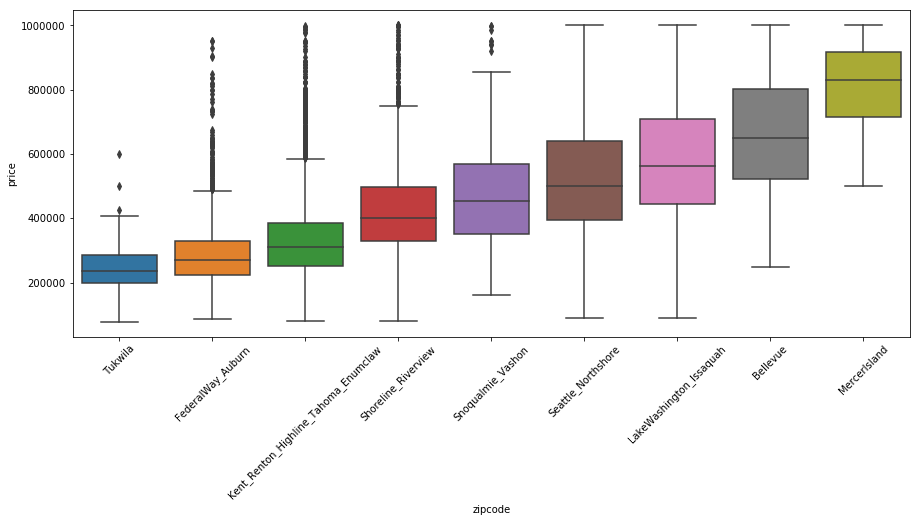

In [42]:
# Visualize zone relationship against price for linearity

plt.figure(figsize = (15,6))
gz = sns.boxplot(x = 'zipcode', y = 'price', data = df, order = grouped_zip.index)
for item in gz.get_xticklabels():
    item.set_rotation(45)

In [43]:
# One hot encode zones to be processed by model

from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
ohe = ohc.fit_transform(df.zipcode.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(ohe, columns = ['SD_' + str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
dfh = pd.concat([df, dfOneHot], axis = 1)
dfh.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode,lat,...,yrs_old,SD_Bellevue,SD_FederalWay_Auburn,SD_Kent_Renton_Highline_Tahoma_Enumclaw,SD_LakeWashington_Issaquah,SD_MercerIsland,SD_Seattle_Northshore,SD_Shoreline_Riverview,SD_Snoqualmie_Vashon,SD_Tukwila
0,221900.0,3,1.00,1.0,0.0,0.0,3,7,Kent_Renton_Highline_Tahoma_Enumclaw,47.5112,...,59,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,538000.0,3,2.25,2.0,0.0,0.0,3,7,Shoreline_Riverview,47.7210,...,63,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,180000.0,2,1.00,1.0,0.0,0.0,3,6,Seattle_Northshore,47.7379,...,82,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,604000.0,4,3.00,1.0,0.0,0.0,5,7,Seattle_Northshore,47.5208,...,49,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,510000.0,3,2.00,1.0,0.0,0.0,3,8,LakeWashington_Issaquah,47.6168,...,28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
dfh.drop(['zipcode'], axis = 1, inplace = True)

# Model features against price

## An iterative top down approach will be taken removing variables as they return a p-value above 0.05 or vif above 10

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [46]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     2788.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:43:59   Log-Likelihood:            -2.6112e+05
No. Observations:               20116   AIC:                         5.223e+05
Df Residuals:                   20097   BIC:                         5.224e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -1.277e+07   9.18e+05    -13.910      0.000   -1.46e+07    -1.1e+07
bedrooms                                 1.337e+04   1021.516     13.090      0.000    1.14e+04    1.54e+04
bathrooms                                5.368e+04   1647.942     32.573      0.000    5.04e+04    5.69e+04
floors                                   2.161e+04   1814.660     11.907      0.000     1.8e+04    2.52e+04
waterfront                               1.339e+05   1.57e+04      8.546      0.000    1.03e+05    1.65e+05
view                                     3.788e+04   1287.890     29.415      0.000    3.54e+04    4.04e+04
condition                                1.801e+04   1258.553     14.310      0.000    1.55e+04    2.05e+04
grade                                    9.567e+04   1013.423     94.400      0.000    9.37e+04    9.77e+04
lat                                      3.144e+05   1.13e+04     27.880      0.000    2.92e+05    3.37e+05
long                                     1.079e+04   7628.835      1.415      0.157   -4160.760    2.57e+04
yrs_old                                  1773.9204     39.273     45.169      0.000    1696.942    1850.899
SD_Bellevue                             -1.316e+06   1.02e+05    -12.898      0.000   -1.52e+06   -1.12e+06
SD_FederalWay_Auburn                    -1.518e+06   1.02e+05    -14.933      0.000   -1.72e+06   -1.32e+06
SD_Kent_Renton_Highline_Tahoma_Enumclaw -1.496e+06   1.01e+05    -14.760      0.000   -1.69e+06    -1.3e+06
SD_LakeWashington_Issaquah              -1.387e+06   1.02e+05    -13.608      0.000   -1.59e+06   -1.19e+06
SD_MercerIsland                         -1.193e+06   1.03e+05    -11.624      0.000   -1.39e+06   -9.92e+05
SD_Seattle_Northshore                   -1.412e+06   1.03e+05    -13.679      0.000   -1.61e+06   -1.21e+06
SD_Shoreline_Riverview                  -1.503e+06   1.03e+05    -14.542      0.000   -1.71e+06    -1.3e+06
SD_Snoqualmie_Vashon                    -1.419e+06      1e+05    -14.146      0.000   -1.62e+06   -1.22e+06
SD_Tukwila                              -1.529e+06   1.03e+05    -14.906      0.000   -1.73e+06   -1.33e+06
==============================================================================
Omnibus:                     1383.508   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2261.409
Skew:                           0.541   Prob(JB):                         0.00
Kurtosis:                       4.236   Cond. No.                     5.48e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigen

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [48]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for bedrooms: 1.43
Variance inflation factor for bathrooms: 2.41
Variance inflation factor for floors: 1.72
Variance inflation factor for waterfront: 1.11
Variance inflation factor for view: 1.16
Variance inflation factor for condition: 1.2
Variance inflation factor for grade: 1.92
Variance inflation factor for lat: 4.65
Variance inflation factor for long: 2.15
Variance inflation factor for yrs_old: 2.38
Variance inflation factor for SD_Bellevue: 100709.06
Variance inflation factor for SD_FederalWay_Auburn: 185149.18
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 397296.95
Variance inflation factor for SD_LakeWashington_Issaquah: 344773.51
Variance inflation factor for SD_MercerIsland: 13871.32
Variance inflation factor for SD_Seattle_Northshore: 587983.23
Variance inflation factor for SD_Shoreline_Riverview: 176602.1
Variance inflation factor for SD_Snoqualmie_Vashon: 65868.21


In [49]:
dfh.drop(['lat', 'long'], axis = 1, inplace = True)

In [50]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for bedrooms: 1.43
Variance inflation factor for bathrooms: 2.41
Variance inflation factor for floors: 1.72
Variance inflation factor for waterfront: 1.1
Variance inflation factor for view: 1.15
Variance inflation factor for condition: 1.2
Variance inflation factor for grade: 1.91
Variance inflation factor for yrs_old: 2.31
Variance inflation factor for SD_Bellevue: 9.11
Variance inflation factor for SD_FederalWay_Auburn: 13.82
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 28.38
Variance inflation factor for SD_LakeWashington_Issaquah: 26.88
Variance inflation factor for SD_MercerIsland: 2.2
Variance inflation factor for SD_Seattle_Northshore: 45.05
Variance inflation factor for SD_Shoreline_Riverview: 13.37
Variance inflation factor for SD_Snoqualmie_Vashon: 5.51


In [51]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2973.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:55:32   Log-Likelihood:            -2.6151e+05
No. Observations:               20116   AIC:                         5.231e+05
Df Residuals:                   20099   BIC:                         5.232e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -5.153e+05   8079.973    -63.779      0.000   -5.31e+05   -4.99e+05
bedrooms                                 1.409e+04   1040.520     13.538      0.000     1.2e+04    1.61e+04
bathrooms                                5.344e+04   1679.365     31.822      0.000    5.01e+04    5.67e+04
floors                                   1.803e+04   1844.180      9.774      0.000    1.44e+04    2.16e+04
waterfront                               1.371e+05   1.59e+04      8.623      0.000    1.06e+05    1.68e+05
view                                     3.577e+04   1306.948     27.368      0.000    3.32e+04    3.83e+04
condition                                 1.67e+04   1281.809     13.032      0.000    1.42e+04    1.92e+04
grade                                    9.756e+04   1029.849     94.730      0.000    9.55e+04    9.96e+04
yrs_old                                  1792.7137     39.417     45.481      0.000    1715.454    1869.974
SD_Bellevue                              6.135e+04   3498.364     17.538      0.000    5.45e+04    6.82e+04
SD_FederalWay_Auburn                    -2.265e+05   2620.199    -86.447      0.000   -2.32e+05   -2.21e+05
SD_Kent_Renton_Highline_Tahoma_Enumclaw -1.729e+05   2080.658    -83.097      0.000   -1.77e+05   -1.69e+05
SD_LakeWashington_Issaquah               1078.8523   2341.187      0.461      0.645   -3510.067    5667.771
SD_MercerIsland                          1.737e+05   8194.932     21.193      0.000    1.58e+05     1.9e+05
SD_Seattle_Northshore                   -2.035e+04   2153.828     -9.450      0.000   -2.46e+04   -1.61e+04
SD_Shoreline_Riverview                   -8.13e+04   2678.843    -30.347      0.000   -8.65e+04    -7.6e+04
SD_Snoqualmie_Vashon                    -6.619e+04   3932.227    -16.832      0.000   -7.39e+04   -5.85e+04
SD_Tukwila                              -1.842e+05   6029.822    -30.549      0.000   -1.96e+05   -1.72e+05
==============================================================================
Omnibus:                     1271.789   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2084.937
Skew:                           0.506   Prob(JB):                         0.00
Kurtosis:                       4.210   Cond. No.                     3.65e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.23e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [52]:
dfh.drop(['SD_LakeWashington_Issaquah'], axis = 1, inplace = True)

In [53]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2973.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:56:11   Log-Likelihood:            -2.6151e+05
No. Observations:               20116   AIC:                         5.231e+05
Df Residuals:                   20099   BIC:                         5.232e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -5.143e+05   9182.075    -56.006      0.000   -5.32e+05   -4.96e+05
bedrooms                                 1.409e+04   1040.520     13.538      0.000     1.2e+04    1.61e+04
bathrooms                                5.344e+04   1679.365     31.822      0.000    5.01e+04    5.67e+04
floors                                   1.803e+04   1844.180      9.774      0.000    1.44e+04    2.16e+04
waterfront                               1.371e+05   1.59e+04      8.623      0.000    1.06e+05    1.68e+05
view                                     3.577e+04   1306.948     27.368      0.000    3.32e+04    3.83e+04
condition                                 1.67e+04   1281.809     13.032      0.000    1.42e+04    1.92e+04
grade                                    9.756e+04   1029.849     94.730      0.000    9.55e+04    9.96e+04
yrs_old                                  1792.7137     39.417     45.481      0.000    1715.454    1869.974
SD_Bellevue                              6.028e+04   3786.026     15.921      0.000    5.29e+04    6.77e+04
SD_FederalWay_Auburn                    -2.276e+05   3046.178    -74.712      0.000   -2.34e+05   -2.22e+05
SD_Kent_Renton_Highline_Tahoma_Enumclaw  -1.74e+05   2497.598    -69.657      0.000   -1.79e+05   -1.69e+05
SD_MercerIsland                          1.726e+05   9059.323     19.052      0.000    1.55e+05     1.9e+05
SD_Seattle_Northshore                   -2.143e+04   2467.728     -8.685      0.000   -2.63e+04   -1.66e+04
SD_Shoreline_Riverview                  -8.238e+04   3135.010    -26.276      0.000   -8.85e+04   -7.62e+04
SD_Snoqualmie_Vashon                    -6.727e+04   4469.985    -15.048      0.000    -7.6e+04   -5.85e+04
SD_Tukwila                              -1.853e+05   6904.588    -26.835      0.000   -1.99e+05   -1.72e+05
==============================================================================
Omnibus:                     1271.789   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2084.937
Skew:                           0.506   Prob(JB):                         0.00
Kurtosis:                       4.210   Cond. No.                     1.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for bedrooms: 22.05
Variance inflation factor for bathrooms: 22.78
Variance inflation factor for floors: 14.1
Variance inflation factor for waterfront: 1.1
Variance inflation factor for view: 1.2
Variance inflation factor for condition: 27.87
Variance inflation factor for grade: 50.77
Variance inflation factor for yrs_old: 6.64
Variance inflation factor for SD_Bellevue: 1.33
Variance inflation factor for SD_FederalWay_Auburn: 1.5
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 2.1
Variance inflation factor for SD_MercerIsland: 1.05
Variance inflation factor for SD_Seattle_Northshore: 3.22
Variance inflation factor for SD_Shoreline_Riverview: 1.53
Variance inflation factor for SD_Snoqualmie_Vashon: 1.18


In [55]:
dfh.drop(['condition'], axis = 1, inplace = True)

In [56]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     3134.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:56:22   Log-Likelihood:            -2.6159e+05
No. Observations:               20116   AIC:                         5.232e+05
Df Residuals:                   20100   BIC:                         5.233e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -4.614e+05   8272.030    -55.777      0.000   -4.78e+05   -4.45e+05
bedrooms                                 1.454e+04   1044.302     13.921      0.000    1.25e+04    1.66e+04
bathrooms                                5.515e+04   1681.251     32.803      0.000    5.19e+04    5.84e+04
floors                                   1.549e+04   1841.575      8.411      0.000    1.19e+04    1.91e+04
waterfront                                1.37e+05    1.6e+04      8.578      0.000    1.06e+05    1.68e+05
view                                     3.574e+04   1312.424     27.233      0.000    3.32e+04    3.83e+04
grade                                    9.719e+04   1033.771     94.012      0.000    9.52e+04    9.92e+04
yrs_old                                  1928.2767     38.179     50.507      0.000    1853.443    2003.110
SD_Bellevue                              6.385e+04   3791.920     16.838      0.000    5.64e+04    7.13e+04
SD_FederalWay_Auburn                    -2.272e+05   3058.797    -74.277      0.000   -2.33e+05   -2.21e+05
SD_Kent_Renton_Highline_Tahoma_Enumclaw -1.733e+05   2507.452    -69.096      0.000   -1.78e+05   -1.68e+05
SD_MercerIsland                          1.779e+05   9088.166     19.573      0.000     1.6e+05    1.96e+05
SD_Seattle_Northshore                   -2.316e+04   2474.478     -9.361      0.000    -2.8e+04   -1.83e+04
SD_Shoreline_Riverview                  -8.351e+04   3146.926    -26.538      0.000   -8.97e+04   -7.73e+04
SD_Snoqualmie_Vashon                    -6.873e+04   4487.292    -15.318      0.000   -7.75e+04   -5.99e+04
SD_Tukwila                              -1.907e+05   6920.800    -27.559      0.000   -2.04e+05   -1.77e+05
==============================================================================
Omnibus:                     1197.892   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1956.825
Skew:                           0.484   Prob(JB):                         0.00
Kurtosis:                       4.182   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for bedrooms: 21.87
Variance inflation factor for bathrooms: 22.73
Variance inflation factor for floors: 14.09
Variance inflation factor for waterfront: 1.1
Variance inflation factor for view: 1.19
Variance inflation factor for grade: 39.45
Variance inflation factor for yrs_old: 5.06
Variance inflation factor for SD_Bellevue: 1.32
Variance inflation factor for SD_FederalWay_Auburn: 1.48
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 2.03
Variance inflation factor for SD_MercerIsland: 1.05
Variance inflation factor for SD_Seattle_Northshore: 3.21
Variance inflation factor for SD_Shoreline_Riverview: 1.52
Variance inflation factor for SD_Snoqualmie_Vashon: 1.18


In [58]:
dfh.drop(['floors'], axis = 1, inplace = True)

In [59]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3341.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:56:25   Log-Likelihood:            -2.6163e+05
No. Observations:               20116   AIC:                         5.233e+05
Df Residuals:                   20101   BIC:                         5.234e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -4.504e+05   8181.472    -55.046      0.000   -4.66e+05   -4.34e+05
bedrooms                                 1.415e+04   1045.105     13.541      0.000    1.21e+04    1.62e+04
bathrooms                                5.817e+04   1645.297     35.356      0.000    5.49e+04    6.14e+04
waterfront                               1.413e+05    1.6e+04      8.836      0.000     1.1e+05    1.73e+05
view                                     3.514e+04   1312.774     26.771      0.000    3.26e+04    3.77e+04
grade                                    9.856e+04   1022.573     96.384      0.000    9.66e+04    1.01e+05
yrs_old                                  1822.0454     36.092     50.484      0.000    1751.303    1892.788
SD_Bellevue                              6.171e+04   3789.954     16.282      0.000    5.43e+04    6.91e+04
SD_FederalWay_Auburn                    -2.279e+05   3062.889    -74.414      0.000   -2.34e+05   -2.22e+05
SD_Kent_Renton_Highline_Tahoma_Enumclaw -1.731e+05   2511.683    -68.899      0.000   -1.78e+05   -1.68e+05
SD_MercerIsland                          1.756e+05   9099.819     19.296      0.000    1.58e+05    1.93e+05
SD_Seattle_Northshore                   -1.903e+04   2429.508     -7.835      0.000   -2.38e+04   -1.43e+04
SD_Shoreline_Riverview                  -8.249e+04   3150.016    -26.187      0.000   -8.87e+04   -7.63e+04
SD_Snoqualmie_Vashon                    -6.723e+04   4491.487    -14.968      0.000    -7.6e+04   -5.84e+04
SD_Tukwila                              -1.894e+05   6930.879    -27.321      0.000   -2.03e+05   -1.76e+05
==============================================================================
Omnibus:                     1205.361   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1949.398
Skew:                           0.489   Prob(JB):                         0.00
Kurtosis:                       4.169   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for bedrooms: 21.86
Variance inflation factor for bathrooms: 21.75
Variance inflation factor for waterfront: 1.1
Variance inflation factor for view: 1.19
Variance inflation factor for grade: 30.65
Variance inflation factor for yrs_old: 4.62
Variance inflation factor for SD_Bellevue: 1.32
Variance inflation factor for SD_FederalWay_Auburn: 1.48
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 2.02
Variance inflation factor for SD_MercerIsland: 1.05
Variance inflation factor for SD_Seattle_Northshore: 3.05
Variance inflation factor for SD_Shoreline_Riverview: 1.51
Variance inflation factor for SD_Snoqualmie_Vashon: 1.17


In [61]:
dfh.drop(['bathrooms', 'bedrooms'], axis = 1, inplace = True)

In [62]:
outcome = 'price'
predictors = dfh.drop(['price'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=dfh).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     3329.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:56:28   Log-Likelihood:            -2.6271e+05
No. Observations:               20116   AIC:                         5.254e+05
Df Residuals:                   20103   BIC:                         5.256e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                               -4.207e+05   8551.509    -49.193      0.000   -4.37e+05   -4.04e+05
waterfront                               1.304e+05   1.69e+04      7.734      0.000    9.74e+04    1.63e+05
view                                     3.887e+04   1381.083     28.145      0.000    3.62e+04    4.16e+04
grade                                    1.195e+05    974.571    122.608      0.000    1.18e+05    1.21e+05
yrs_old                                  1351.5907     34.889     38.739      0.000    1283.205    1419.977
SD_Bellevue                              6.437e+04   3994.353     16.114      0.000    5.65e+04    7.22e+04
SD_FederalWay_Auburn                     -2.31e+05   3229.909    -71.533      0.000   -2.37e+05   -2.25e+05
SD_Kent_Renton_Highline_Tahoma_Enumclaw -1.725e+05   2649.646    -65.099      0.000   -1.78e+05   -1.67e+05
SD_MercerIsland                          1.798e+05   9601.732     18.723      0.000    1.61e+05    1.99e+05
SD_Seattle_Northshore                   -2.158e+04   2545.164     -8.479      0.000   -2.66e+04   -1.66e+04
SD_Shoreline_Riverview                  -8.764e+04   3322.171    -26.381      0.000   -9.42e+04   -8.11e+04
SD_Snoqualmie_Vashon                    -6.673e+04   4737.960    -14.085      0.000    -7.6e+04   -5.74e+04
SD_Tukwila                              -2.006e+05   7309.762    -27.443      0.000   -2.15e+05   -1.86e+05
==============================================================================
Omnibus:                     1049.939   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1482.483
Skew:                           0.483   Prob(JB):                         0.00
Kurtosis:                       3.913   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
dfhi = dfh.drop(['price'], axis = 1)

for i in range(len(dfhi.columns[:-1])):
    v = vif(np.matrix(dfhi[:-1]), i)
    print('Variance inflation factor for {}: {}'.format(dfhi.columns[i], round(v, 2)))

Variance inflation factor for waterfront: 1.1
Variance inflation factor for view: 1.18
Variance inflation factor for grade: 4.9
Variance inflation factor for yrs_old: 3.5
Variance inflation factor for SD_Bellevue: 1.32
Variance inflation factor for SD_FederalWay_Auburn: 1.47
Variance inflation factor for SD_Kent_Renton_Highline_Tahoma_Enumclaw: 2.01
Variance inflation factor for SD_MercerIsland: 1.05
Variance inflation factor for SD_Seattle_Northshore: 3.02
Variance inflation factor for SD_Shoreline_Riverview: 1.51
Variance inflation factor for SD_Snoqualmie_Vashon: 1.17


# Model Validation

## Validate model predictive ability using train, test, split & evaluate error term assumptions using qq and residual regression plots

In [64]:
dfh.isnull().sum()

price                                      0
waterfront                                 0
view                                       0
grade                                      0
yrs_old                                    0
SD_Bellevue                                0
SD_FederalWay_Auburn                       0
SD_Kent_Renton_Highline_Tahoma_Enumclaw    0
SD_MercerIsland                            0
SD_Seattle_Northshore                      0
SD_Shoreline_Riverview                     0
SD_Snoqualmie_Vashon                       0
SD_Tukwila                                 0
dtype: int64

In [65]:
y = dfh[['price']]
X = dfh.drop(['price'], axis = 1)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

16092 4024 16092 4024


In [68]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [69]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 12929161693.071041
Test Mean Squarred Error: 12874671746.669722


In [70]:
# Calculate RMSE

print(np.sqrt(train_mse))

113706.47164111215


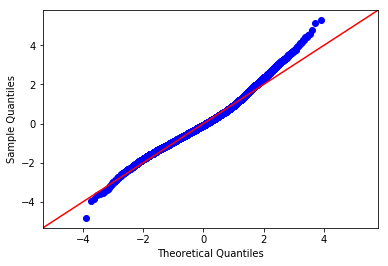

In [71]:
# Check normality of residuals assumption using qq plot

resid = model.resid

fig = sm.graphics.qqplot(resid, dist = stats.norm, line = '45', fit = True)

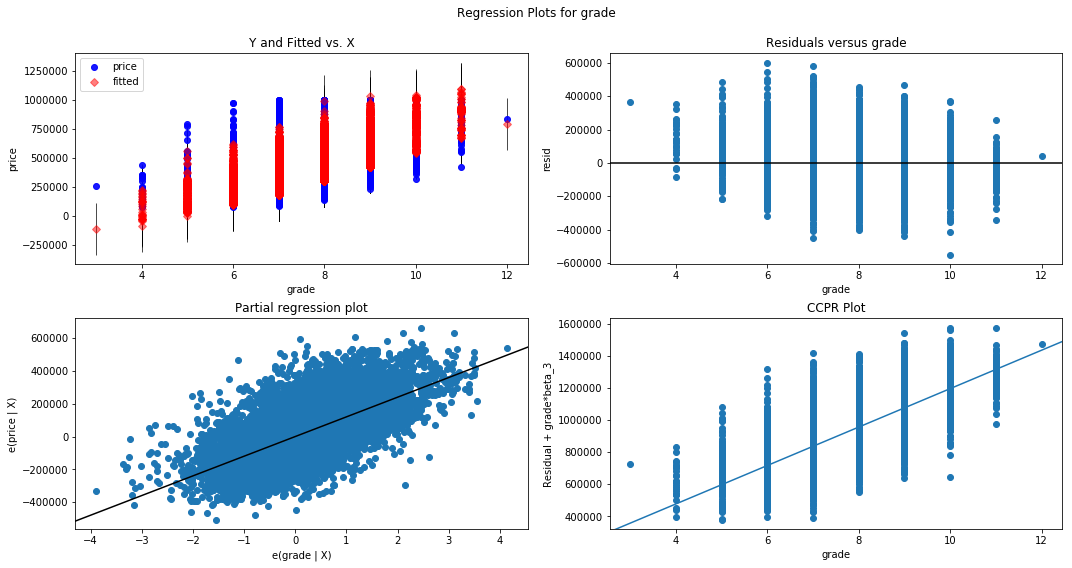

In [37]:
# Check independence and homoscedasticity of error term assumptions using stats models .plot_regress_exog for each
# independent variable

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

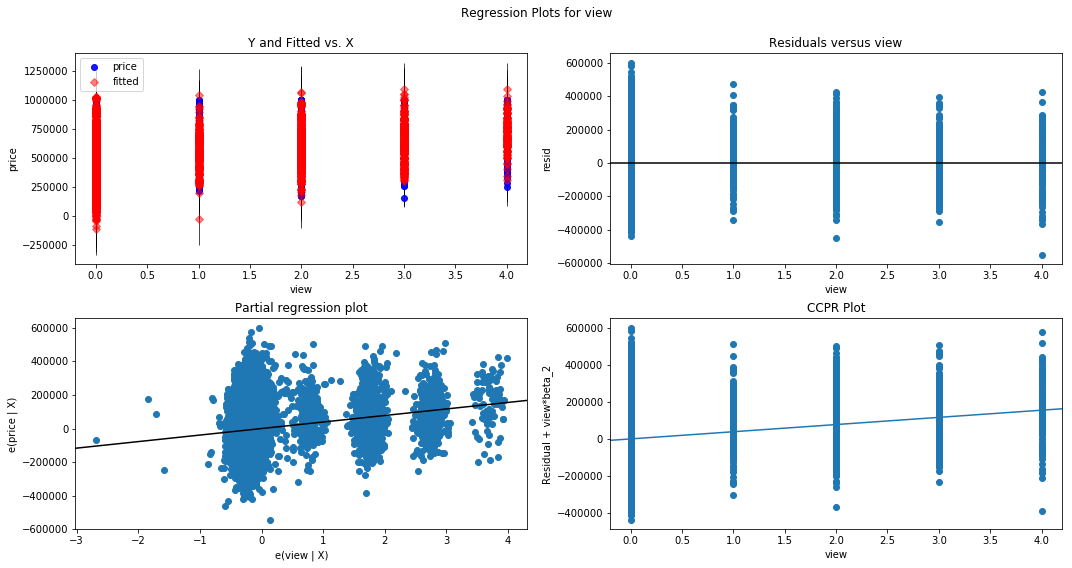

In [38]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "view", fig=fig)
plt.show()

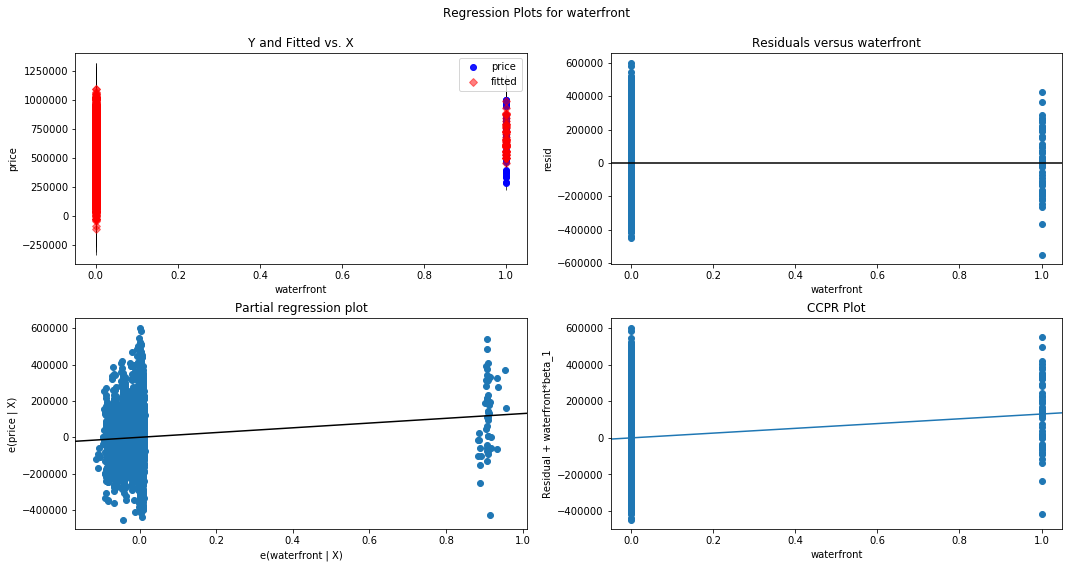

In [39]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "waterfront", fig=fig)
plt.show()

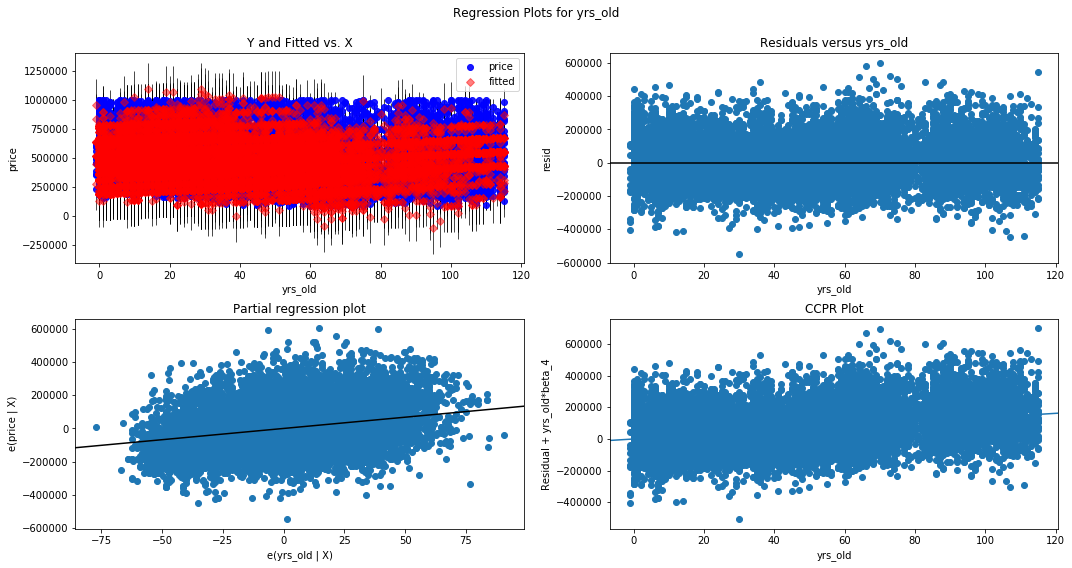

In [40]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "yrs_old", fig=fig)
plt.show()

# Cross Validation

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [73]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

0.6624315157664774
-12986478034.064615
-12958448184.601187


# Model Summary

## This final model was built and tuned by removing features individually that had high p-values and vif. This model meets all regression assumptions and has an r-squared of 0.67 and a MSE of $113,500